In [1]:
### TODO:
# 1. Do feature engineering on group level instead of user level
# 2. Separate data between first person mode and free for all mode
# 3. Eliminate cheaters and anomalies
# 4. Develop prediction funcgion
#    - Final ranking per match can be determined using this formula -> 100/maxPlace, as ranking interval

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
from matplotlib import pyplot as plt

In [3]:
### Read training data
train = pd.read_csv('train_V2.csv.zip')

In [4]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [5]:
train.head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

In [7]:
matchTypes = train.groupby('matchId')['matchType'].first().value_counts()

In [8]:
matchTypes.index

Index(['squad-fpp', 'duo-fpp', 'squad', 'solo-fpp', 'duo', 'solo',
       'normal-squad-fpp', 'normal-duo-fpp', 'normal-solo-fpp', 'crashfpp',
       'flaretpp', 'normal-solo', 'normal-squad', 'normal-duo', 'flarefpp',
       'crashtpp'],
      dtype='object')

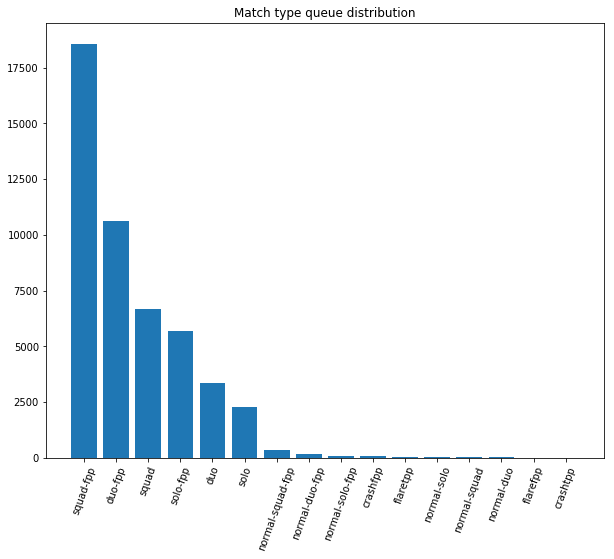

In [9]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(matchTypes.index)),matchTypes.values,align='center')
ax.set_xticks(np.arange(len(matchTypes.index)))
ax.set_xticklabels(matchTypes.index,rotation=70)
plt.title("Match type queue distribution")
plt.show()


### 1. Group Level Inspection and Feature Engineering

Features need to be generated on a group level. Below is the explanation. Let's inspect data for matchId **a10357fd1a4a91**

In [10]:
### Inspect a match data
matchA_df = train[train.matchId == 'a10357fd1a4a91']

In [11]:
### Inspect a group
matchA_df[matchA_df.groupId == '654c638629b8fc']

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
675029,34673dfdd74aae,654c638629b8fc,a10357fd1a4a91,0,2,292.80,2,0,1,10,...,0,0.0,0,0.0,0,0,359.90,3,1464,0.4815
1698681,cc2bdb64c03e47,654c638629b8fc,a10357fd1a4a91,0,0,71.72,2,0,0,18,...,0,0.0,0,0.0,0,0,174.00,2,1581,0.4815
2315578,39d06340eceb4b,654c638629b8fc,a10357fd1a4a91,0,0,54.18,0,0,1,55,...,0,0.0,0,0.0,0,0,279.60,2,1578,0.4815
2384171,3c522b145e176b,654c638629b8fc,a10357fd1a4a91,0,0,0.00,0,0,0,57,...,0,0.0,0,0.0,0,0,230.70,3,1593,0.4815
3124027,8d7d8bcb5d4d60,654c638629b8fc,a10357fd1a4a91,0,0,0.00,0,0,0,58,...,0,0.0,0,0.0,0,0,385.40,3,1444,0.4815
3794495,bc3165e8591dc6,654c638629b8fc,a10357fd1a4a91,0,0,0.00,0,0,0,59,...,0,0.0,0,0.0,0,0,13.05,0,1433,0.4815
3901118,b5594651b8c66e,654c638629b8fc,a10357fd1a4a91,1,1,100.00,1,0,0,56,...,0,0.0,0,0.0,0,0,441.60,2,1504,0.4815
3910749,37e2da1e80c3d2,654c638629b8fc,a10357fd1a4a91,2,0,312.10,2,1,0,17,...,1,0.0,0,0.0,1,0,291.10,7,1567,0.4815


In [12]:
### select groupIds in a match
playerGroups = matchA_df[['Id','groupId']]

In [13]:
### Number of players per group
playerCountGroup = playerGroups.groupby('groupId',as_index=False).agg({'Id':'count'}).sort_values('Id').rename(columns={"Id":"players"}).reset_index(drop=True)

In [14]:
playerCountGroup

,groupId,players
0,1d31d15e045c4d,1
1,2cdf256e3c2c1d,1
2,0b4bf93ca082a4,2
3,30e393959e45ac,2
4,a27667dbecd7d7,2
5,168d1fc8ebe03c,3
6,2af5c87d86546d,3
7,2f8336736f3be2,3
8,d7d1cd054b0f5b,3
9,c92eb4405f4d3a,3


Various number of players in a group may exist in one match. Player queuing solo will be in a group with only 1 member.

In [15]:
### Total players in this match
print("Total players: {}".format(playerCountGroup.players.sum()))
print("Total groups: {}".format(playerCountGroup.groupId.count()))

Total players: 96
Total groups: 26


Now notice the distribution of placement ranking which we would like to predict

In [16]:
### Notice the percentage ranking
matchA_df[['winPlacePerc']].drop_duplicates().sort_values('winPlacePerc').reset_index(drop=True)

,winPlacePerc
0,0.0000
1,0.0370
2,0.0741
3,0.1111
4,0.1481
5,0.1852
6,0.2222
7,0.2593
8,0.2963
9,0.3333


There are 26 placements which actually correspond to the number of groups. The interval could be retrieved using:

In [17]:
### The increment of winPlacePerc is retrieved using:
print((100/float(26))/100)

0.038461538461538464


Because the ranking is spread based on the number of groups in one match, group level features need to be generated!

In [27]:
### Generate group level features    

def generate_group_level_features(dataset,feature_columns=['kills','assists','boosts']):
    features = dataset[["matchId","groupId","winPlacePerc",*feature_columns]].reset_index(drop=True)
    plain = features[["matchId","groupId","winPlacePerc"]].drop_duplicates().reset_index(drop=True)
    
    ### predefined basic statistic operations
    _stats = ['max','min','sum','mean','std']
    
    for f in feature_columns:
        for s in _stats:
            new_field = '{s}_{f}'.format(s=s,f=f)
            print(new_field)
            plain = pd.merge(plain,
                features.groupby(["matchId","groupId"],as_index=False)\
                .agg({f:s}).rename(columns={f:new_field}).fillna(0)[["matchId","groupId",new_field]].drop_duplicates(),
                on=['matchId','groupId'],how='inner'
            )
    return plain.reset_index(drop=True)
    

In [29]:
### sample of group level features
#generate_group_level_features(matchA_df)

In [30]:
import time
s = time.time()
groupLevelFeatures = generate_group_level_features(train)
e = time.time()
print("elapsed {}s".format(e-s))

max_kills
min_kills
sum_kills
mean_kills
std_kills
max_assists
min_assists
sum_assists
mean_assists
std_assists
max_boosts
min_boosts
sum_boosts
mean_boosts
std_boosts
elapsed 283.9673399925232s


In [33]:
groupLevelFeatures.to_csv("groupLevelFeatures.csv",index=False)

### 2. Split train test data

In [226]:
from sklearn.model_selection import train_test_split
train_matchId, test_matchId = train_test_split(unique_matchId,test_size=0.2)

In [232]:
train_df = groupLevelFeatures[groupLevelFeatures.matchId.isin(train_matchId)].\
                                                         sort_values(by=['matchId','winPlacePerc'],
                                                                     ascending=False).reset_index(drop=True)
test_df = groupLevelFeatures[groupLevelFeatures.matchId.isin(test_matchId)].\
                                                        sort_values(by=['matchId','winPlacePerc'],
                                                                     ascending=False).reset_index(drop=True)

In [245]:
train_matches = train_df[['matchId']]
train_matches['count'] = 1

test_matches = test_df[['matchId']]
test_matches['count'] = 1

/Users/bramth/miniconda2/envs/dst/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/bramth/miniconda2/envs/dst/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [267]:
features = train_df.drop(['matchId','groupId','winPlacePerc'],1).columns

In [255]:
train_y = train_df['winPlacePerc'].values
train_x = train_df.drop(['matchId','groupId','winPlacePerc'],1).values
train_group_x = train_matches.groupby("matchId",as_index=False).count().\
                              sort_values(by=['matchId'],ascending=False)['count'].values

In [256]:
test_y = test_df['winPlacePerc'].values
test_x = test_df.drop(['matchId','groupId','winPlacePerc'],1).values
test_group_x = test_matches.groupby("matchId",as_index=False).count().\
                            sort_values(by=['matchId'],ascending=False)['count'].values

### 3. Train XGBoost Model

### Notes

Ensemble Learning
1. *Bagging*:
    Generate weak learners, in the end the prediction is the result of voting or getting weighting average of 
    predictors. Weak learners could be learned in parallel. One example of bagging: random forest
2. *Boosting*:
    Sequentially learn the predictors, thus learning predictor at time t depends on predictor at time t-1
    Boosting learns by modifying the data by weights for each iteration. Data points which are mistakenly 
    predicted will be assigned more weights than the correct ones. In the end, the predictors resulted from each 
    iteration will be again weighted to produce the final result.

In [297]:
### XGBoost with `rank:pairwise` objective parameter implement LambdaMARTs, a gradient boosted regression tree
### with pairwise loss function as the objective function

import xgboost as xgb
params = {'objective': 'rank:pairwise', 'learning_rate': 0.1,
          'gamma': 1.0, 'min_child_weight': 0.1,
          'max_depth': 6, 'n_estimators': 100}
model = xgb.sklearn.XGBRanker(**params)
model.fit(train_x, train_y, train_group_x,
          eval_set=[(test_x, test_y)], eval_group=[test_group_x], eval_metric="ndcg")

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
     colsample_bytree=1, gamma=1.0, learning_rate=0.1, max_delta_step=0,
     max_depth=6, min_child_weight=0.1, missing=None, n_estimators=100,
     n_jobs=-1, nthread=None, objective='rank:pairwise', random_state=0,
     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
     subsample=1)

In [299]:
model.feature_importances_

array([0.07843138, 0.01317904, 0.10800385, 0.19366764, 0.05528769,
       0.02362584, 0.00900032, 0.01783992, 0.12375442, 0.02812601,
       0.04243009, 0.00658952, 0.10045002, 0.16602379, 0.03359048],
      dtype=float32)

In [300]:
features

Index(['max_kills', 'min_kills', 'sum_kills', 'mean_kills', 'std_kills',
       'max_assists', 'min_assists', 'sum_assists', 'mean_assists',
       'std_assists', 'max_boosts', 'min_boosts', 'sum_boosts', 'mean_boosts',
       'std_boosts'],
      dtype='object')

In [298]:
model.evals_result['eval_0']['ndcg'][-1]

0.698706

In [302]:
predict_y = model.predict(test_x)

In [305]:
test_y[:50]

array([1.    , 0.9792, 0.9583, 0.9375, 0.9167, 0.8958, 0.875 , 0.8542,
       0.8333, 0.7917, 0.7708, 0.75  , 0.7292, 0.7083, 0.6875, 0.6667,
       0.6458, 0.625 , 0.6042, 0.5833, 0.5625, 0.5417, 0.5208, 0.5   ,
       0.4792, 0.4583, 0.4375, 0.4167, 0.3958, 0.375 , 0.3542, 0.3333,
       0.2917, 0.2708, 0.25  , 0.2292, 0.2083, 0.1875, 0.1667, 0.1458,
       0.125 , 0.1042, 0.0833, 0.0625, 0.0417, 0.0208, 0.    , 1.    ,
       0.9896, 0.9792])

In [307]:
predict_y[:50]

array([ 4.298759  ,  3.017995  ,  1.7691667 ,  2.4268959 ,  0.33955976,
        0.8372288 ,  2.1051717 ,  3.0273948 , -0.84029293, -0.84029293,
        1.7917778 ,  1.3565059 ,  1.5995853 ,  0.53694296,  2.2115228 ,
       -0.41561097,  0.35322827,  2.1025717 ,  0.48568332,  0.4705562 ,
       -0.18715703,  0.4317113 ,  0.8372288 ,  1.0043198 , -0.78953445,
        1.0022988 , -0.25386262, -0.24968225, -0.25386262, -0.5888181 ,
        0.23670664,  0.35322827, -0.84029293, -0.84029293, -0.78953445,
       -0.41561097, -0.84029293, -1.0669757 , -1.0220795 , -0.84029293,
       -0.84029293, -0.78953445, -0.78953445, -0.5609834 , -0.41561097,
       -0.84029293, -0.84029293,  3.0576687 ,  3.6018481 ,  3.2500787 ],
      dtype=float32)

### TODO

### - Separate Game Modes data

(TODO) <br>
There are several game modes / match types in PUBG <br>
https://pubg.gamepedia.com/Game_Modes <br>
Patterns might differ for example between First Person Mode and Third Person Mode even though the players are on solo queue game.

### - Eliminate Anomalies

(TODO) <br>
There are already existing kernel out there mentioning anomalies or cheaters in PUBG matches. <br>
We need to adopt some of them.

### - Prediction Functions

(TODO) <br>
Because how dynamic a winPlacePerc value can be, custom prediction function needs to be developed